# Unit 1 - Cost of Teacher

Group members:

- Ole Magnus Laerum
- Piotr Franc

## Task description
Use the dataset BostonHousing2 (target value is target_column) with the following train1/train2/test partition. Use the dataset train1 to explore learning methods and techniques in a way that you want to reduce the amount of data used for training without compromising the performance of the model too much. Once the best methodology is selected, use it with train2 to show a plot of performance (RMSE) vs instances employed measured with the test partition. Grow this plot incrementally (i.e, add new instances to the already used instances) Select the instances of train2 without using the class label of the instances already not employed.

In [61]:
### ---- Import libraries ------------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor


Train1 size: (202, 13)
Train2 size: (152, 13)
Test size: (152, 13)
------------------------------ RMSE values for 9 models:------------------------------------------------------------
Linear Regression: 5.31
Decision Tree: 6.55
Random Forest: 3.44
XGBoost: 3.11
Gradient Boosting: 3.10
SVR: 8.13
Ridge Regression: 5.31
k-NN: 6.76
Stacking: 3.22

Best model: Gradient Boosting with RMSE: 3.10
------------------------------ Running incremental learning with Gradient Boosting:------------------------------------------------------------


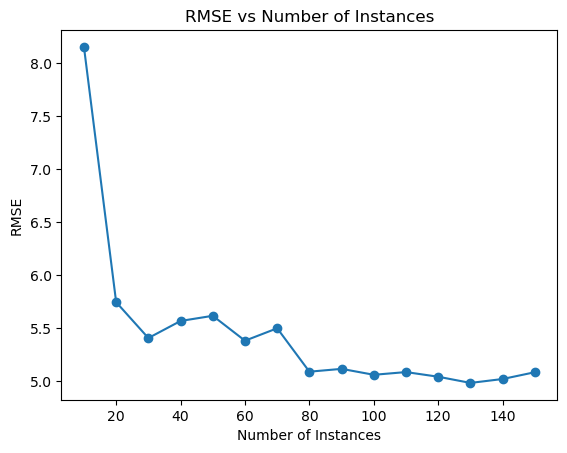

In [62]:
### ---- Import the dataset -------------------------------------------------------------------------------------------------

boston = fetch_openml(data_id=531, as_frame=True, parser='pandas')
data = boston.frame

# Remove column index 4 to match R code
mddata = data.drop(columns=[data.columns[4]])

np.random.seed(280)

train1, temp = train_test_split(mddata, test_size=0.6, random_state=280)
train2, test = train_test_split(temp, test_size=0.5, random_state=280)

print("Train1 size:", train1.shape)
print("Train2 size:", train2.shape)
print("Test size:", test.shape)

### --- Preprocessing the dataset -- Fix the datatypes that are categories and not float64 -------------------------------------

train1["CHAS"] = train1["CHAS"].astype(int)
train1["RAD"] = train1["RAD"].astype(int)

train2["CHAS"] = train2["CHAS"].astype(int)
train2["RAD"] = train2["RAD"].astype(int)

test["CHAS"] = test["CHAS"].astype(int)
test["RAD"] = test["RAD"].astype(int)

target_column = "MEDV"

def train_and_evaluate(train, test, target_column, model):
    model.fit(train.drop(columns=[target_column]), train[target_column])

    preds = model.predict(test.drop(columns=[target_column]))
    mse = np.sqrt(mean_squared_error(test[target_column], preds))

    return mse

### ---- Models ----------------------------------------------------------------------------------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=1000, random_state=13),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3),
    "SVR": SVR(kernel='rbf'),
    "Ridge Regression": Ridge(alpha=1.0),
    "k-NN": KNeighborsRegressor(n_neighbors=5),
    "Stacking": StackingRegressor(
        estimators=[
            ('lr', LinearRegression()),
            ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
            ("gbr", GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3))
        ],
        final_estimator=Ridge()
    )
}


### ---- Train and Evaluate ----------------------------------------------------------------------------------------------------

print("-"*30 + f" RMSE values for {len(models)} models:" + "-" * 60)

results = {}
for name, model in models.items():
    rmse = train_and_evaluate(train1, test, target_column, model)
    results[name] = rmse
    print(f"{name}: {rmse:.2f}")

best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

print(f"\nBest model: {best_model_name} with RMSE: {results[best_model_name]:.2f}")


### ---- Incremental Learning ----------------------------------------------------------------------------------------------------

print("-"*30 + f" Running incremental learning with {best_model_name}:" + "-" * 60)
rmse_values = []
num_instances = []

for size in range(10, len(train2), 10):  
    partial_train2 = train2.iloc[:size]
    best_model.fit(partial_train2.drop(columns=[target_column]), partial_train2[target_column])
    
    preds = best_model.predict(test.drop(columns=[target_column]))
    rmse = np.sqrt(mean_squared_error(test[target_column], preds))
    
    rmse_values.append(rmse)
    num_instances.append(size)

    

### ---- Plotting ----------------------------------------------------------------------------------------------------

plt.plot(num_instances, rmse_values, marker='o', linestyle='-')
plt.xlabel("Number of Instances")
plt.ylabel("RMSE")
plt.title("RMSE vs Number of Instances")
plt.show()


### TO DO

1. Time each model, how long it takes
2. Give a score based on RMSE per time, select the one with the highest
3. Find where he said "Not just select the best one" 
4. Read up on models, which is good, which should I use.
5. Figure out how the report should be 